# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [2]:
df = pd.read_csv("../data/checker_submits.csv")

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
del df['timestamp']

In [4]:
cat_var = ['uid' ,'labname']
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[cat_var]).toarray()

In [5]:
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_var))
df = pd.concat([df, encoded_df], axis=1)
df.drop(columns=cat_var, inplace=True)

In [6]:
cont_var = ['numTrials', 'hour']
scalar = StandardScaler()

In [7]:
scaled = scalar.fit_transform(df[cont_var])
df[cont_var] = scaled

In [8]:
df.to_csv('../data/dayofweek.csv', index=False)

In [28]:
print(df)
accuracy = accuracy_score(df['dayofweek'], [df['dayofweek'].mode().values] * len(df['dayofweek']))
print(accuracy)

      numTrials      hour  dayofweek  uid_user_0  uid_user_1  uid_user_10  \
0     -0.788667 -2.562352          4         0.0         0.0          0.0   
1     -0.756764 -2.562352          4         0.0         0.0          0.0   
2     -0.724861 -2.562352          4         0.0         0.0          0.0   
3     -0.692958 -2.562352          4         0.0         0.0          0.0   
4     -0.661055 -2.562352          4         0.0         0.0          0.0   
...         ...       ...        ...         ...         ...          ...   
1681  -0.533442  0.945382          3         0.0         0.0          0.0   
1682  -0.629151  0.945382          3         0.0         1.0          0.0   
1683  -0.597248  0.945382          3         0.0         1.0          0.0   
1684  -0.565345  0.945382          3         0.0         1.0          0.0   
1685  -0.533442  0.945382          3         0.0         1.0          0.0   

      uid_user_11  uid_user_12  uid_user_13  uid_user_14  ...  labname_lab0

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [10]:
X = df.drop('dayofweek', axis=1) 
y = df['dayofweek']
model = LogisticRegression(random_state=21, fit_intercept=False)
model.fit(X, y)

LogisticRegression(fit_intercept=False, random_state=21)

In [11]:
accuracy = accuracy_score(y, model.predict(X))
accuracy

0.6405693950177936

In [12]:
def plot_feature(coefs, features, n=10):
    feature_importance = coefs.sum(axis=0)
    indices = np.argsort(feature_importance)[::-1][:n]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.barh(np.arange(n), feature_importance[indices], color='b', align='center')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(np.array(features)[indices])
    ax.invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'Top-{n} Most Important Features')
    plt.show()

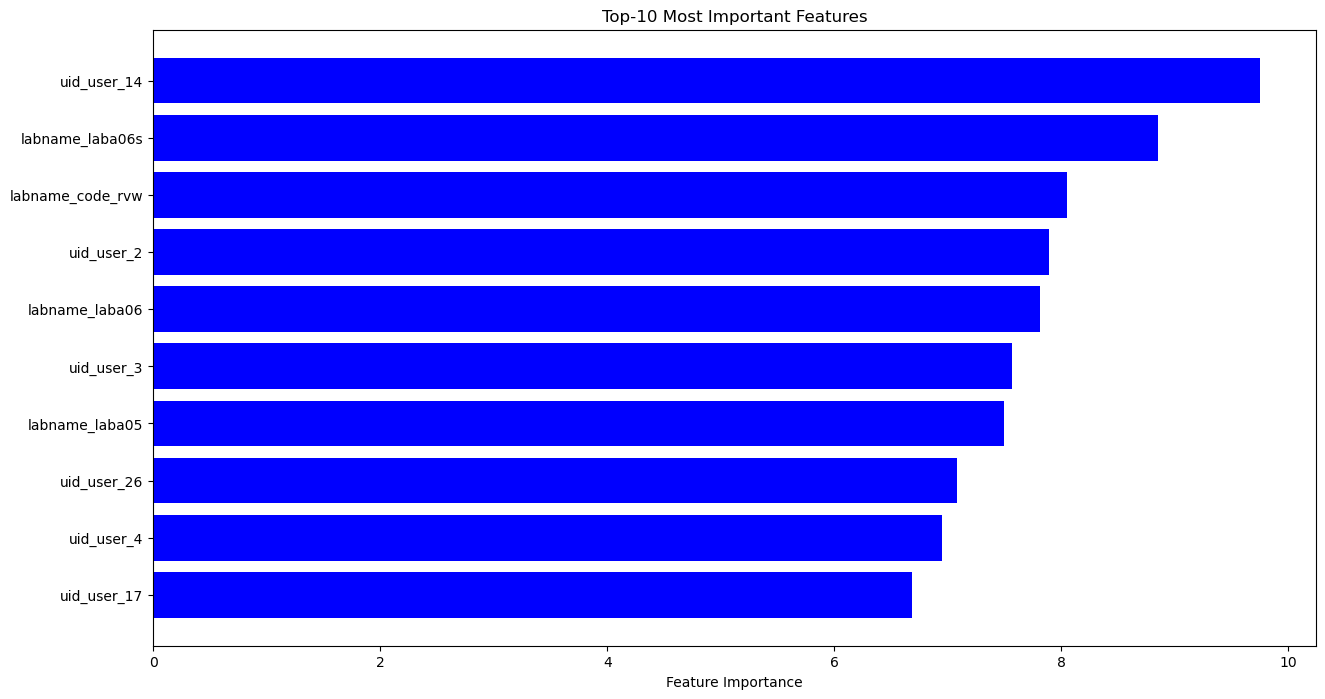

In [13]:
plot_feature(abs(model.coef_), X.columns)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [14]:
svc_model = SVC(kernel='linear', probability=True, random_state=21)
ovr_svc = OneVsRestClassifier(svc_model).fit(X, y)
print(accuracy_score(y, ovr_svc.predict(X)))

0.6126927639383155


In [15]:
svc_model_rbf = SVC(kernel='rbf', probability=True, random_state=21)
pred_rbf = OneVsRestClassifier(svc_model_rbf).fit(X, y)
print(accuracy_score(y, pred_rbf.predict(X)))

0.8641755634638197


In [16]:
svc_model_poly = SVC(kernel='poly', probability=True, random_state=21)
pred_poly = OneVsRestClassifier(svc_model_poly).fit(X, y)
print(accuracy_score(y, pred_poly.predict(X)))

0.8653618030842231


In [17]:
svc_model_sigmoid = SVC(kernel='sigmoid', probability=True, random_state=21)
pred_sigmoid = OneVsRestClassifier(svc_model_sigmoid).fit(X, y)
print(accuracy_score(y, pred_sigmoid.predict(X)))

0.3499406880189798


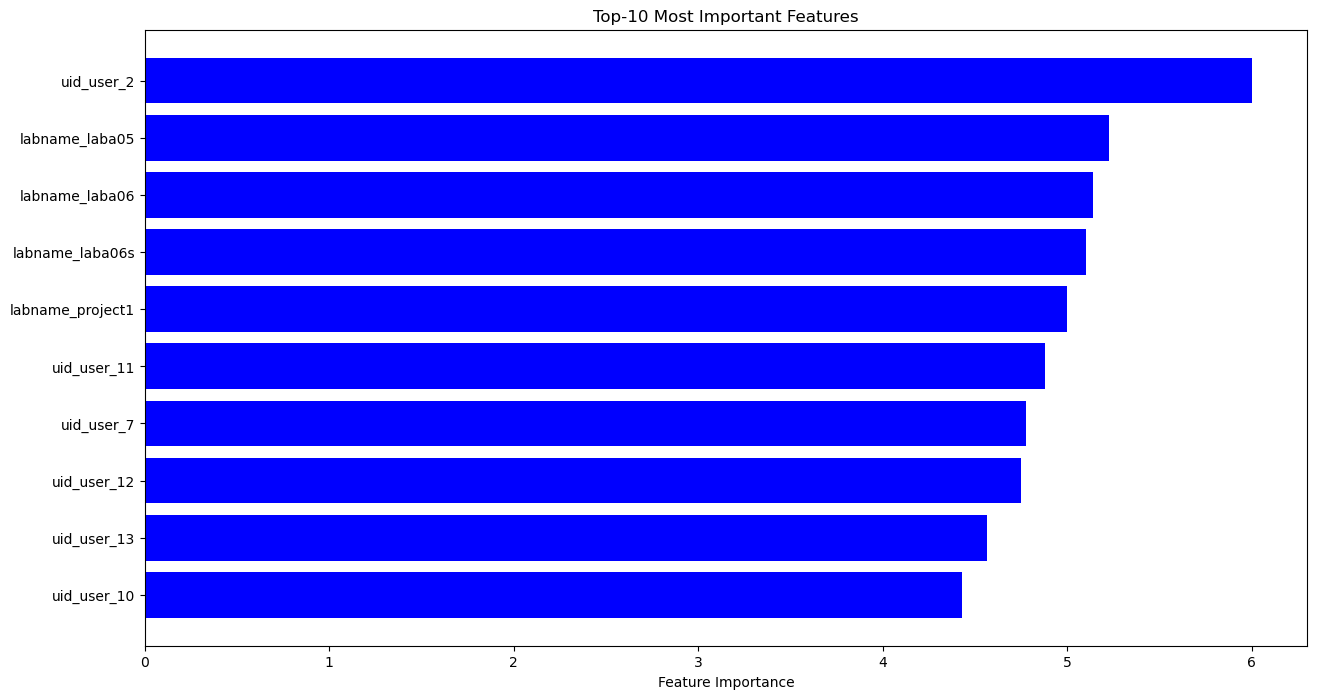

In [18]:
feature_importances = np.sum([np.abs(estimator.coef_) for estimator in ovr_svc.estimators_], axis=0)
plot_feature(feature_importances, X.columns)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [19]:
DTC_model = DecisionTreeClassifier(random_state=21, max_depth=4)
DTC_model.fit(X, y)
print(accuracy_score(y, DTC_model.predict(X)))

0.5516014234875445


In [20]:
DTC_model_10 = DecisionTreeClassifier(random_state=21, max_depth=10)
DTC_model_10.fit(X, y)
print(accuracy_score(y, DTC_model_10.predict(X)))

0.8196915776986952


In [21]:
def plot_feature_tree(coefs, features, n=10):
    feature_importance = np.array(coefs)
    indices = np.argsort(feature_importance)[::-1][:n]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.barh(np.arange(n), feature_importance[indices], color='b', align='center')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(np.array(features)[indices])
    ax.invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'Top-{n} Most Important Features')
    plt.show()

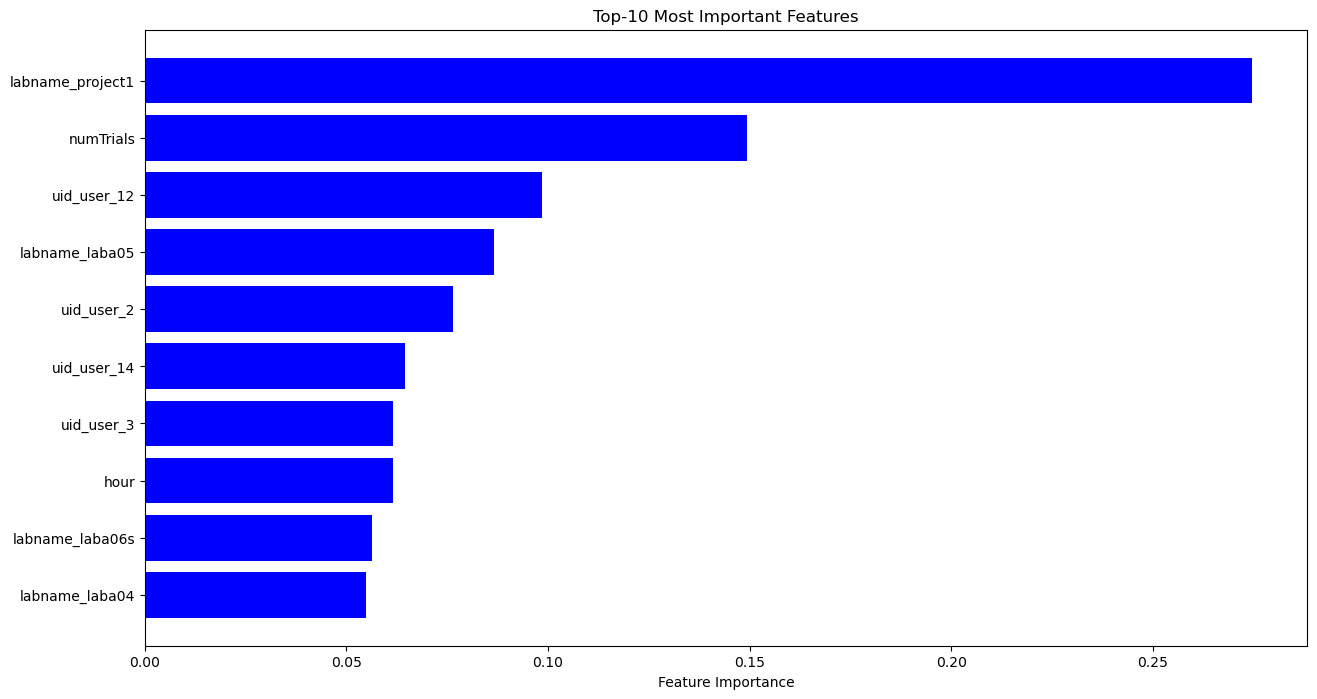

In [22]:
plot_feature_tree(abs(DTC_model.feature_importances_), X.columns)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [23]:
RFC = RandomForestClassifier(random_state=21, max_depth=25, n_estimators=100)
RFC.fit(X, y)
print(accuracy_score(y, RFC.predict(X)))

1.0


In [24]:
RFC_lower = RandomForestClassifier(random_state=21, max_depth=20, n_estimators=80)
RFC_lower.fit(X, y)
print(accuracy_score(y, RFC_lower.predict(X)))

0.9952550415183867


In [25]:
RFC_higher = RandomForestClassifier(random_state=21, max_depth=50, n_estimators=150)
RFC_higher.fit(X, y)
print(accuracy_score(y, RFC_higher.predict(X)))

1.0


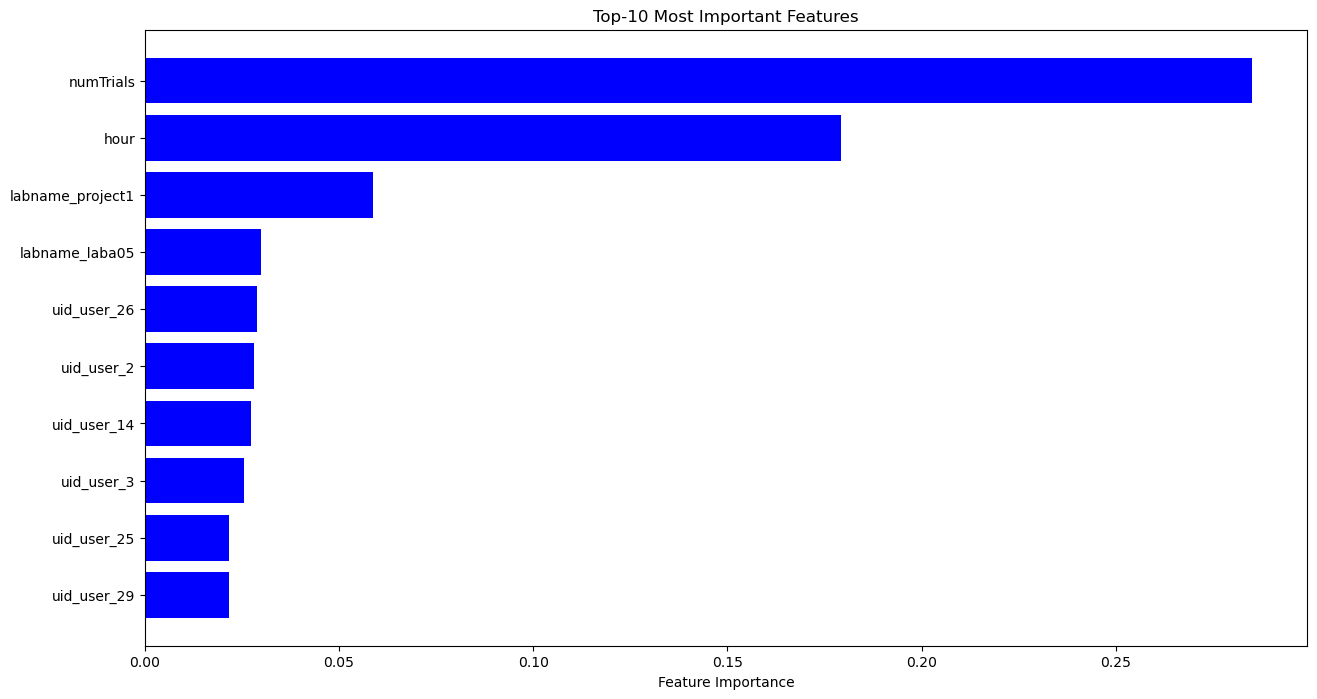

In [26]:
plot_feature_tree(abs(RFC.feature_importances_), X.columns)